# EDA-undersampling
对tf-idf中表现较好的几个模型使用eda加undersampling的方法进行优化，增加样本数，减少样本不均的问题。

## 方法定义

In [1]:

import numpy as np
import os
import nltk

import torch
import torch.nn
import torchtext.vocab as vocab
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
import pandas as pd
import warnings
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LinearRegression
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore")

In [2]:
def load_data(filename):
    column = ['name', 'cat']
    df = pd.read_csv(filename, encoding='utf_8_sig', usecols=column)
    # df = df[:5000]
    # print(df.columns)
    #df.drop(df[df.cat== 'Seafood'].index, inplace= True )
    df.columns = ['name', 'cat']
    texts = df['name'].values
    df = df.fillna(-1)
    # labels = np.argmax(df[df.columns[-4:]].values, axis=1)
    labels = df['cat'].values
    label2id = {l: i for i, l in enumerate(set(labels))}
    id2label = {i: l for l, i in label2id.items()}
    labels = [label2id[l] for l in labels]
    return texts, labels, id2label

In [3]:
def text_preprocess(text):
    text = str(text)
    english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%', '\'', '/']
    text = "".join([(a if a not in english_punctuations else " ") for a in text])
    text = " ".join(nltk.tokenize.word_tokenize(text.lower()))
    return text

In [4]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

## 数据处理

In [5]:
train_texts, train_labels, id2label = load_data("../data_cleaning/eda_data_augmented.csv")  
train_texts = [text_preprocess(t) for t in train_texts]

In [6]:
test_texts, test_labels, id2label = load_data("../data_cleaning/test.csv")  
test_texts = [text_preprocess(t) for t in test_texts]

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer 

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

train_features, tfidf_vectorizer = tfidf(train_texts)
test_features = tfidf_vectorizer.transform(test_texts)

print("train data len:", len(train_texts))
print("test data len:", len(test_texts))
print("id2label",id2label)

train data len: 456297
test data len: 8948
id2label {0: 'Personal Care', 1: 'Pantry', 2: 'Fresh Foods & Bakery', 3: 'Beer, Cider & Wine', 4: 'Kitchen, Dining & Household', 5: 'Drinks', 6: 'Baby, Toddler & Kids', 7: 'Chilled, Frozen & Desserts', 8: 'Pets'}


In [8]:
train_features

<456297x19474 sparse matrix of type '<class 'numpy.float64'>'
	with 2586559 stored elements in Compressed Sparse Row format>

In [9]:
test_features

<8948x19474 sparse matrix of type '<class 'numpy.float64'>'
	with 48182 stored elements in Compressed Sparse Row format>

In [10]:
from imblearn.under_sampling import RandomUnderSampler
# 使用RandomUnderSampler方法进行欠抽样处理
def under_sampling(x,y):
    model_RandomUnderSampler = RandomUnderSampler() # 建立RandomUnderSampler模型对象
    x_RandomUnderSampler_resampled, y_RandomUnderSampler_resampled =model_RandomUnderSampler.fit_sample(x,y) # 输入数据并作欠抽样处理
    return x_RandomUnderSampler_resampled, y_RandomUnderSampler_resampled


x_train,y_train = under_sampling(train_features,train_labels)

x_test = test_features
y_test = test_labels



In [11]:
x_train

<90117x19474 sparse matrix of type '<class 'numpy.float64'>'
	with 536222 stored elements in Compressed Sparse Row format>

In [12]:
len(y_train)

90117

In [13]:
x_test

<8948x19474 sparse matrix of type '<class 'numpy.float64'>'
	with 48182 stored elements in Compressed Sparse Row format>

In [15]:
len(y_test)
type(y_test)

list

## 模型优化

In [14]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

KNN

k is 5


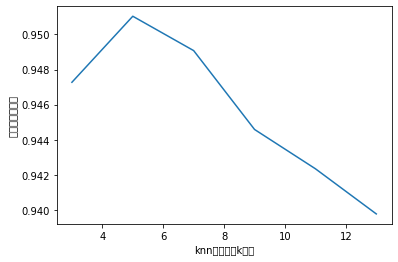

In [19]:
from sklearn.model_selection import cross_val_score
k_range=[3,5,7,9,11,13]
k_score=[]
max=0
index=0
for i in k_range:
    knn = KNeighborsClassifier(n_neighbors=i)
    score=cross_val_score(knn,x_train,y_train,cv=5,scoring='accuracy')
    if score.mean() > max:
        max = score.mean()
        index = i
    k_score.append(score.mean())

print('k is %d' %index)
plt.plot(k_range,k_score)
plt.xlabel('knn中近邻数k的值')
plt.ylabel('交叉验证精确度')
plt.show()


In [15]:
#KNN
model = KNeighborsClassifier(n_neighbors=9)
model.fit(x_train, y_train)
knn_predict_labels = model.predict(x_test)
evaluation(knn_predict_labels, y_test, id2label, "knn")

knn: acc:0.9482565936522128, recall:0.967758646162319, f1 score:0.9493208357507579
                             precision    recall  f1-score   support

              Personal Care       0.98      0.98      0.98      1379
                     Pantry       0.98      0.90      0.94      2935
       Fresh Foods & Bakery       0.85      0.94      0.89       876
         Beer, Cider & Wine       0.98      0.99      0.98       680
Kitchen, Dining & Household       0.98      0.97      0.98       977
                     Drinks       0.89      0.99      0.94       566
       Baby, Toddler & Kids       0.88      0.98      0.92       232
 Chilled, Frozen & Desserts       0.91      0.96      0.94       963
                       Pets       0.95      1.00      0.97       340

                   accuracy                           0.95      8948
                  macro avg       0.93      0.97      0.95      8948
               weighted avg       0.95      0.95      0.95      8948



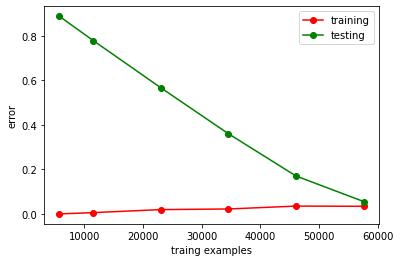

In [27]:
knn = KNeighborsClassifier(n_neighbors=9)
train_sizes,train_score,test_score = learning_curve(knn,x_train,y_train,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()

## SVM

In [16]:
# undersampled
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
model = OneVsRestClassifier(SVC(C=1000, gamma=0.001, kernel='rbf'))
model.fit(x_train, y_train) 
svm_predict_labels = model.predict(x_test)
evaluation(svm_predict_labels, y_test, id2label, "svm")

svm: acc:0.9730666070630308, recall:0.9822509076970937, f1 score:0.9764706037787734
                             precision    recall  f1-score   support

              Personal Care       0.98      0.99      0.99      1379
                     Pantry       0.99      0.95      0.97      2935
       Fresh Foods & Bakery       0.92      0.96      0.94       876
         Beer, Cider & Wine       0.99      1.00      1.00       680
Kitchen, Dining & Household       0.99      0.99      0.99       977
                     Drinks       0.97      0.99      0.98       566
       Baby, Toddler & Kids       0.97      0.99      0.98       232
 Chilled, Frozen & Desserts       0.93      0.98      0.96       963
                       Pets       0.99      1.00      0.99       340

                   accuracy                           0.97      8948
                  macro avg       0.97      0.98      0.98      8948
               weighted avg       0.97      0.97      0.97      8948



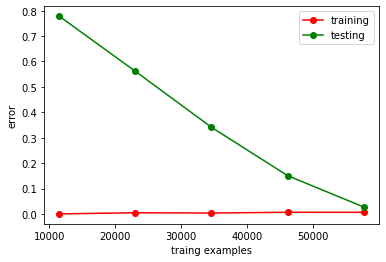

In [28]:
from sklearn.svm import SVC
train_sizes,train_score,test_score = learning_curve(SVC(C=1000, gamma=0.001, kernel='rbf'),x_train,y_train,train_sizes=[0.1,0.2,0.4,0.6,0.8,1],cv=5,scoring='accuracy')
train_error =  1- np.mean(train_score,axis=1)
test_error = 1- np.mean(test_score,axis=1)
plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
plt.legend(loc='best')
plt.xlabel('traing examples')
plt.ylabel('error')
plt.show()
